# TTT4185 Machine learning for Speech technology

## Computer assigment 3b:  Regression analysis

Regression analysis is used to estimate/measure the relationship between an _independent_ variable, say $x$, and a _dependent_ variable, say $y$. One of the simplest regression problems is 
\begin{equation}
y = ax + b
\end{equation}
where $a$ and $b$ are constants. In practice our observations will be contaminated by noise, so we have
\begin{equation}
y = ax + b + n,
\end{equation}
where $n$ is noise, eg. measurement errors. This particular problem is called _linear regression_.

We will have a look at _non-linear regression_, using deep neural networks. Here we are looking at general regression problems in the form 
\begin{equation}
y = f(x) + n.
\end{equation}

We generate our data according to the function $f(x) = x^2 + \cos(20x) \text{ sign}(x)$, obtaining a set of observations $\{(x_i,y_i)\}$.

Then we assume we do not know the underlying function and we try to recover an approximation of $f$ only using the observations $\{(x_i,y_i)\}$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

# Want to use GPU resources in google notebook. Validating that this can be found:

# %tensorflow_version 2.x
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

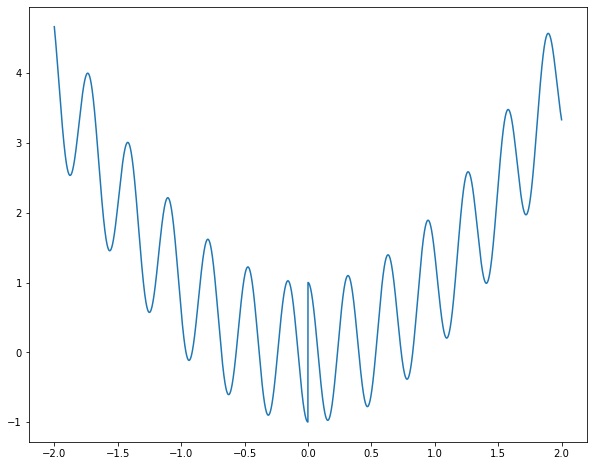

In [2]:
# Define function
def f(x):
    return x**2 + np.cos(20*x)*np.sign(x)

# Setup some simulation parameters
# Number of observations
N = 5000

# Plot a "clean" version of the relationship between x and y
plt.figure(figsize=(10, 8))
x = np.linspace(-2,2,N)
plt.plot(x,f(x))
plt.show()

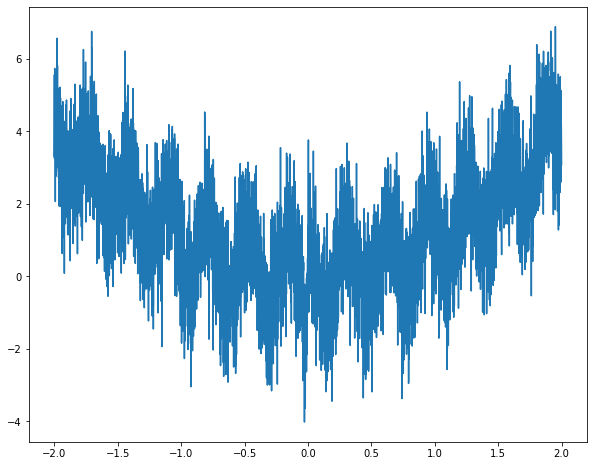

In [3]:
# Create a noisy version of the observations
y = f(x) + np.random.randn(len(x))
plt.figure(figsize=(10, 8))
plt.plot(x,y)
plt.show()

One way to perform regression is to assume that the data is generated using a set of functions from a cerain family, for example polynomials of order $p$,
\begin{equation}
\hat f(x) = a_0 + a_1 x + a_2 x^2 \ldots a_p x^p.
\end{equation}
Then regression corresponds to fitting the parameters in the model. Let us see how this works out before using our neural networks.

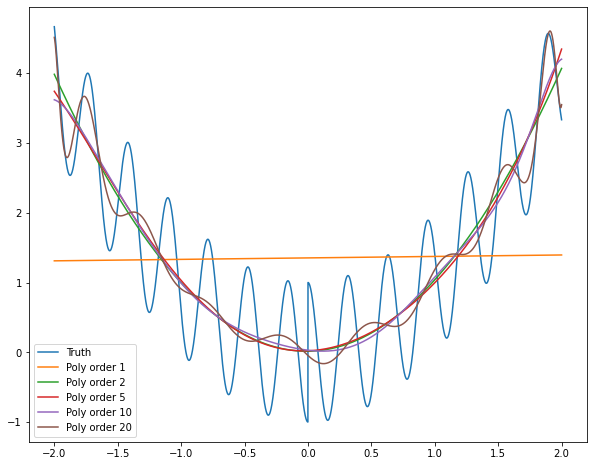

In [4]:
# Give a set of polynomial orders to try
P = [1, 2, 5, 10, 20]

# Define estimator function. Arguments are inout variable, observation and polynomial order
# Returns a set of polynomial coefficients
def reg_estimator(x,y,p):
    # Use simple ls approach
    N = len(x)
    H = np.zeros((N,p+1))
    for col in range(p+1):
        H[:,col] = x**col
    iHtH = np.linalg.inv(np.dot(H.T,H))
    theta = np.dot(np.dot(iHtH,H.T),y)
    return theta

# Computes fx) = c_0 + c_1x + c_2 x^2 ... c_p x^p
def poly(x, C):
    # compute p(x) for coeffs in c
    y = 0*x
    for p, c in enumerate(C):
        y += c*x**p        
    return y

plt.figure(figsize=(10,8))
plt.plot(x,f(x),label="Truth")
for p in P:
    C = reg_estimator(x,y,p)
    plt.plot(x,poly(x,C),label="Poly order " + str(p))
plt.legend()
plt.show()

## Problem 1
Play with different $p$ to see how close you can get to the true function.

Note: Very high $p$ will give numerical problems.

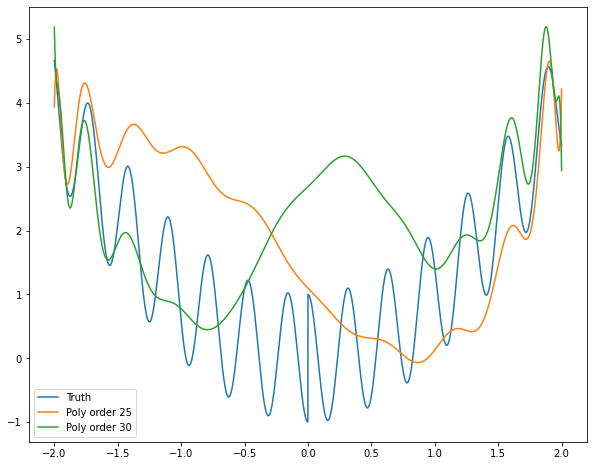

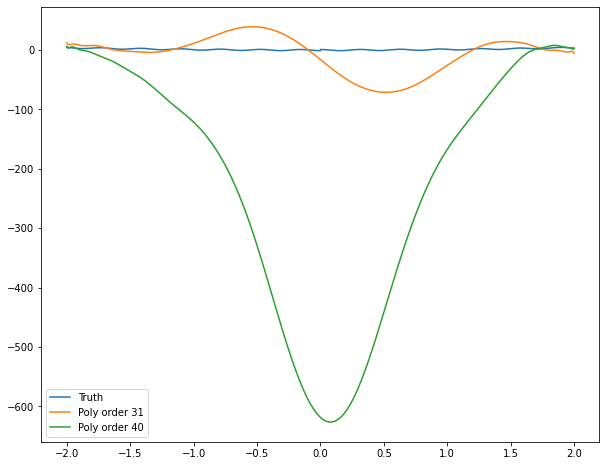

In [5]:
P_play = [25, 30]
plt.figure(figsize=(10,8))
plt.plot(x,f(x),label="Truth")
for p in P_play:
    C = reg_estimator(x,y,p)
    plt.plot(x,poly(x,C),label="Poly order " + str(p))
plt.legend()
plt.show()

P_play = [31, 40]
plt.figure(figsize=(10,8))
plt.plot(x,f(x),label="Truth")
for p in P_play:
    C = reg_estimator(x,y,p)
    plt.plot(x,poly(x,C),label="Poly order " + str(p))
plt.legend()
plt.show()

# We observe that polynomial fitting does not work very well for sinusoidal signals. It can though, work well for the signal in a small area, as we observe in the start and end here. Also we can observe that very high orders lead to big deviations.

In what follows we will use a deep neural network to approximate $f$. We set this up below

In [6]:
# Ceate a model with a single hidden layer. Note that input and output has
# dimension one
M = 512
model = keras.Sequential([
    keras.layers.Dense(M, activation=tf.nn.relu, input_dim=1),
    keras.layers.Dense(1)
])

model.summary()
# Train the model
model.compile(loss='mean_squared_error',
              optimizer="adam",
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


We train the network by using $x$ as an input and the squared error between the network output $\hat y$ and the observed value $y$ as a loss
\begin{equation}
 L = \frac{1}{N} \sum_n (\hat y - y)^2
\end{equation}

We first try our network on clean data to check if it works.

In [7]:
# train the model
history = model.fit(x, f(x), epochs=1000, batch_size=128, verbose=False)

Using the variable `history`, plot the evolution of the loss during training. 

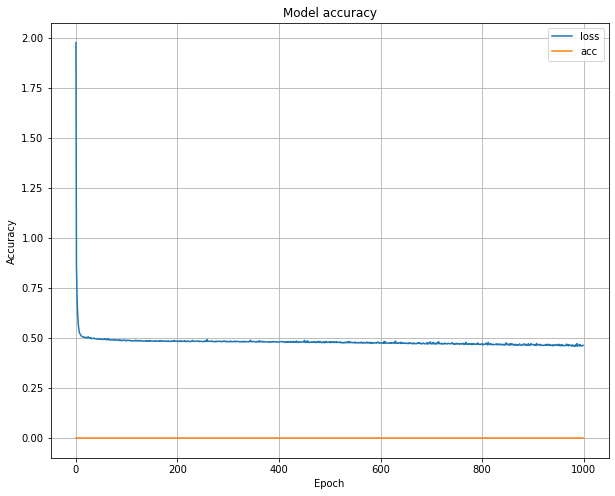

In [8]:
# Visualize the training results
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['accuracy'],label='acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model accuracy')
plt.grid()
plt.legend()
plt.show()

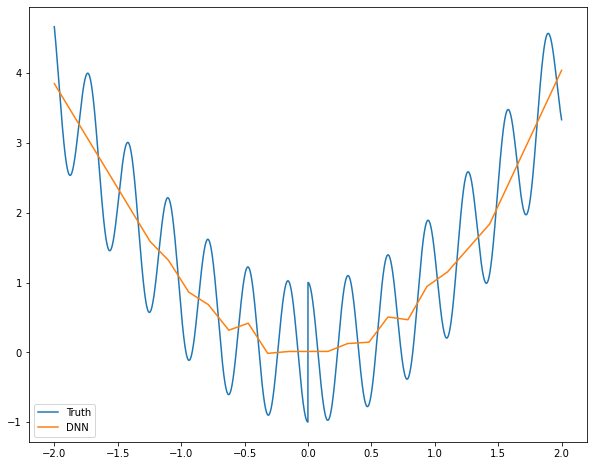

In [9]:
# Compute \hat y from the network and compare this to the true f(x)
z = model.predict(x)
plt.figure(figsize=(10,8))
plt.plot(x,f(x),label="Truth")
plt.plot(x,z,label="DNN")
plt.legend()
plt.show()

## Problem 2
Try increasing the number of nodes in the network to see if the results can be improved.

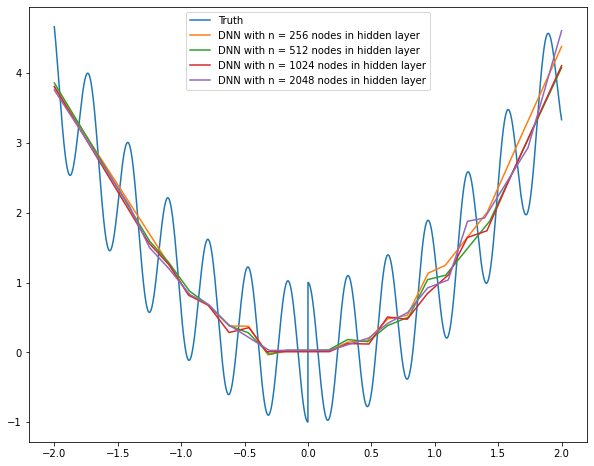

In [10]:
# Ceate a model with a single hidden layer. Note that input and output has
# dimension one
M = [256, 512, 1024, 2048]
z = []

for n in M:
    model = keras.Sequential([
        keras.layers.Dense(n, activation=tf.nn.relu, input_dim=1),
        keras.layers.Dense(1)
    ])

    # model.summary()
    # Train the model
    model.compile(loss='mean_squared_error',
                  optimizer="adam",
                  metrics=['accuracy'])

    # Compute \hat y from the network and compare this to the true f(x)
    history = model.fit(x, f(x), epochs=1000, batch_size=128, verbose=False)
    z.append(model.predict(x))

plt.figure(figsize=(10,8))
plt.plot(x,f(x),label="Truth")

for ind, z_vals in enumerate(z):
    plt.plot(x,z[ind],label="DNN with n = " + str(M[ind]) + ' nodes in hidden layer')
    plt.legend()
    
plt.show()


# We see that there really isnt much improvement in increasing the number of nodes.

Next we will use a deep network with more than one hidden layer.

In [11]:
# Create a model with multiple hidden layers. Note that input and output has
# dimension one
M = 16
model = keras.Sequential([
    keras.layers.Dense(M, activation=tf.nn.relu, input_dim=1),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(1)
])
model.summary()

# Train the model
model.compile(loss='mean_squared_error',
              optimizer="adam",
              metrics=['accuracy'])

history = model.fit(x, f(x), epochs=1000, batch_size=128, verbose=False)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 16)                32        
_________________________________________________________________
dense_11 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_12 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_13 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 17        
Total params: 865
Trainable params: 865
Non-trainable params: 0
_________________________________________________________________


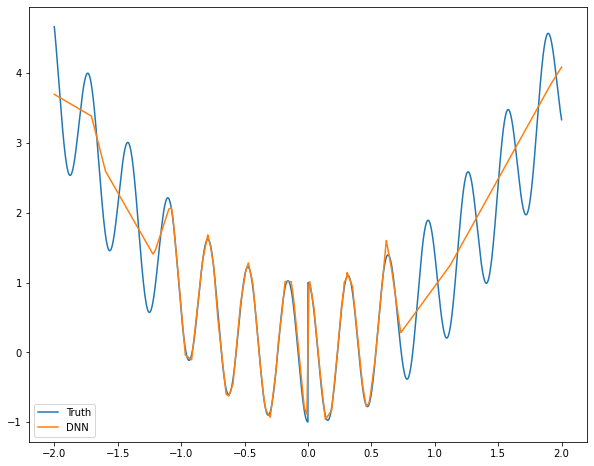

In [12]:
z = model.predict(x)
plt.figure(figsize=(10,8))
plt.plot(x,f(x),label="Truth")
plt.plot(x,z,label="DNN")
plt.legend()
plt.show()

# We see dramatic improvement by increasing the number of layers.

## Problem 3
Try increasing the number of hidden nodes per layer until performance is satisfactory. Can the same effect be achieved by just adding more layers?

In [13]:
M = [32, 64, 128]
z = []

for n in M:
    model = keras.Sequential([
        keras.layers.Dense(n, activation=tf.nn.relu, input_dim=1),
        keras.layers.Dense(n, activation=tf.nn.relu),
        keras.layers.Dense(n, activation=tf.nn.relu),
        keras.layers.Dense(n, activation=tf.nn.relu),
        keras.layers.Dense(1)
    ])

    # model.summary()
    # Train the model
    model.compile(loss='mean_squared_error',
                  optimizer="adam",
                  metrics=['accuracy'])

    # Compute \hat y from the network and compare this to the true f(x)
    history = model.fit(x, f(x), epochs=1000, batch_size=128, verbose=False)
    z.append(model.predict(x))

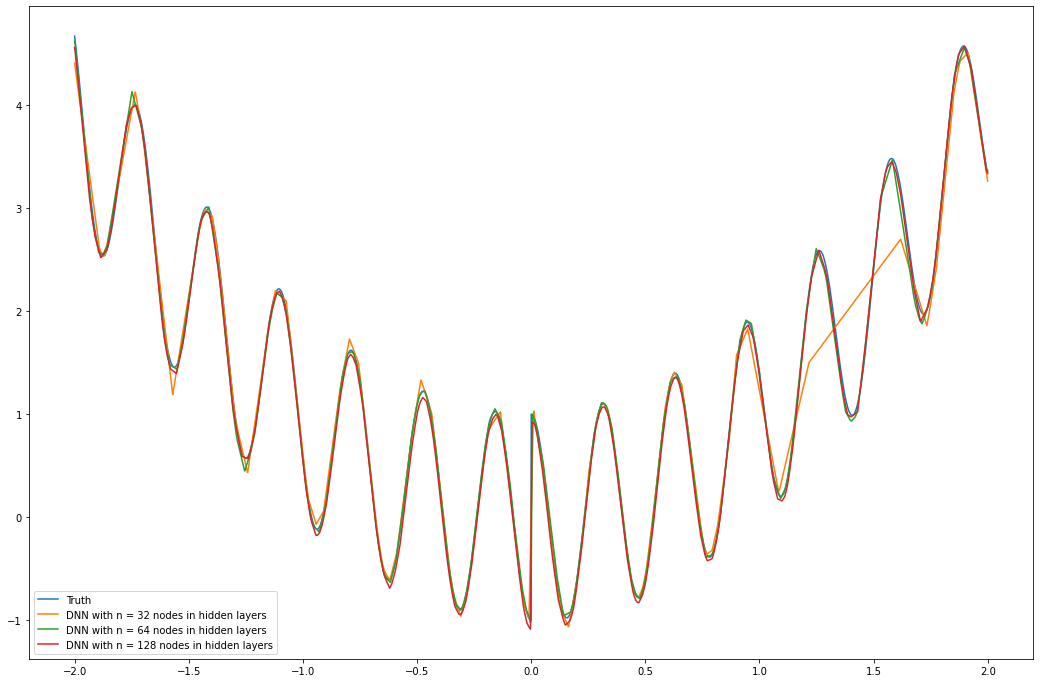

In [14]:
plt.figure(figsize=(18,12))
plt.plot(x,f(x),label="Truth")

for ind, z_vals in enumerate(z):
    plt.plot(x,z_vals,label="DNN with n = " + str(M[ind]) + ' nodes in hidden layers')
    plt.legend()
    
plt.show()

# I deem the performance of the DNN with n = 128 nodes in the hidden layers satisfactory.

# Attempt to achieve the same by adding layers:

In [15]:
M = 16

layers = [4, 8, 12, 32]
z = []

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(8, input_shape=(16,)))

for n in layers:
    model = keras.Sequential()
    keras.layers.Dense(M, activation=tf.nn.relu, input_dim=1)
    for i in range(n):
        model.add(keras.layers.Dense(M, activation=tf.nn.relu))
    model.add(keras.layers.Dense(1))
    # Train the model
    model.compile(loss='mean_squared_error',
                  optimizer="adam",
                  metrics=['accuracy'])

    history = model.fit(x, f(x), epochs=1000, batch_size=128, verbose=False)
    z.append(model.predict(x))

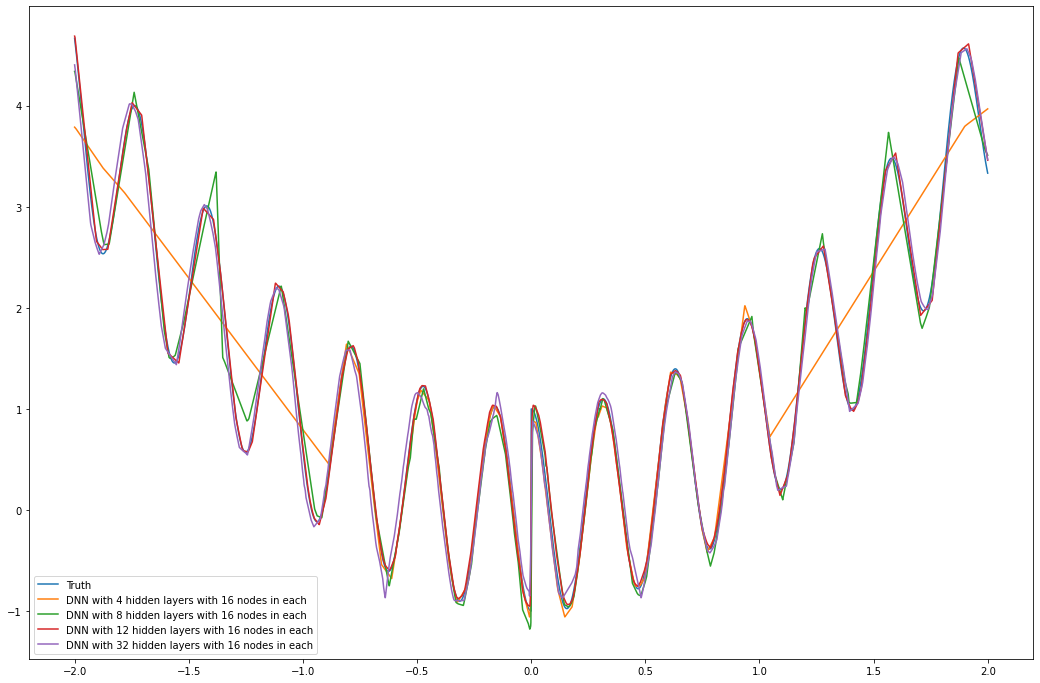

In [16]:
plt.figure(figsize=(18,12))
plt.plot(x,f(x),label="Truth")

for ind, z_vals in enumerate(z):
    plt.plot(x,z_vals,label="DNN with " + str(layers[ind]) + ' hidden layers with ' + str(M) + ' nodes in each')
    plt.legend()
    
plt.show()

# It seems that adding layers can have almost the same effect as adding nodes. It is at least more effective than adding nodes to one hidden layer.

## Problem 4
Using the best setup from the previous problem, train a model using the noisy data.

In [17]:
n = 128

model = keras.Sequential([
    keras.layers.Dense(n, activation=tf.nn.relu, input_dim=1),
    keras.layers.Dense(n, activation=tf.nn.relu),
    keras.layers.Dense(n, activation=tf.nn.relu),
    keras.layers.Dense(n, activation=tf.nn.relu),
    keras.layers.Dense(1)
])
# model.summary()
# Train the model
model.compile(loss='mean_squared_error',
              optimizer="adam",
              metrics=['accuracy'])
# Compute \hat y from the network and compare this to the true f(x)
history = model.fit(x, y, epochs=1000, batch_size=128, verbose=False)
z = model.predict(x)

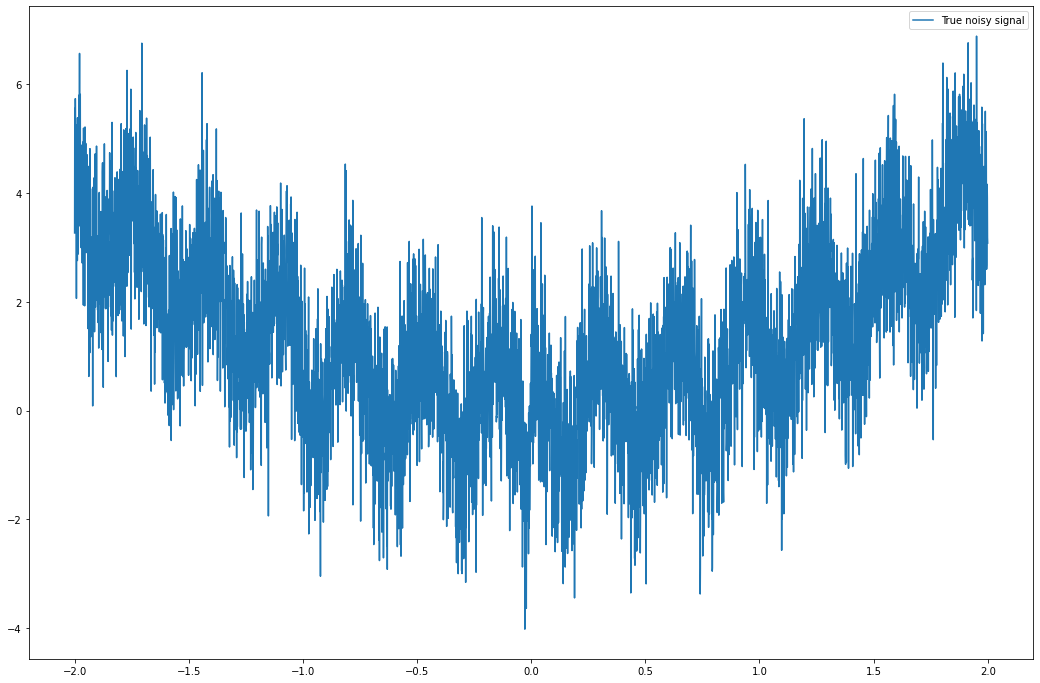

In [18]:
plt.figure(figsize=(18,12))
plt.plot(x,y,label="True noisy signal")
plt.legend()   
plt.show()

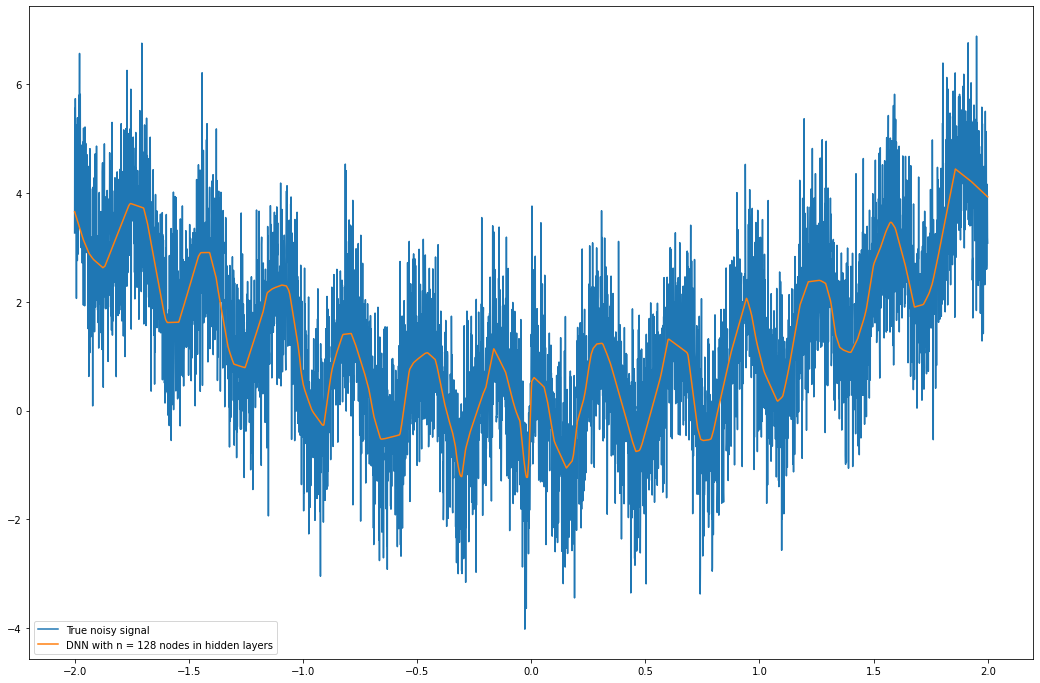

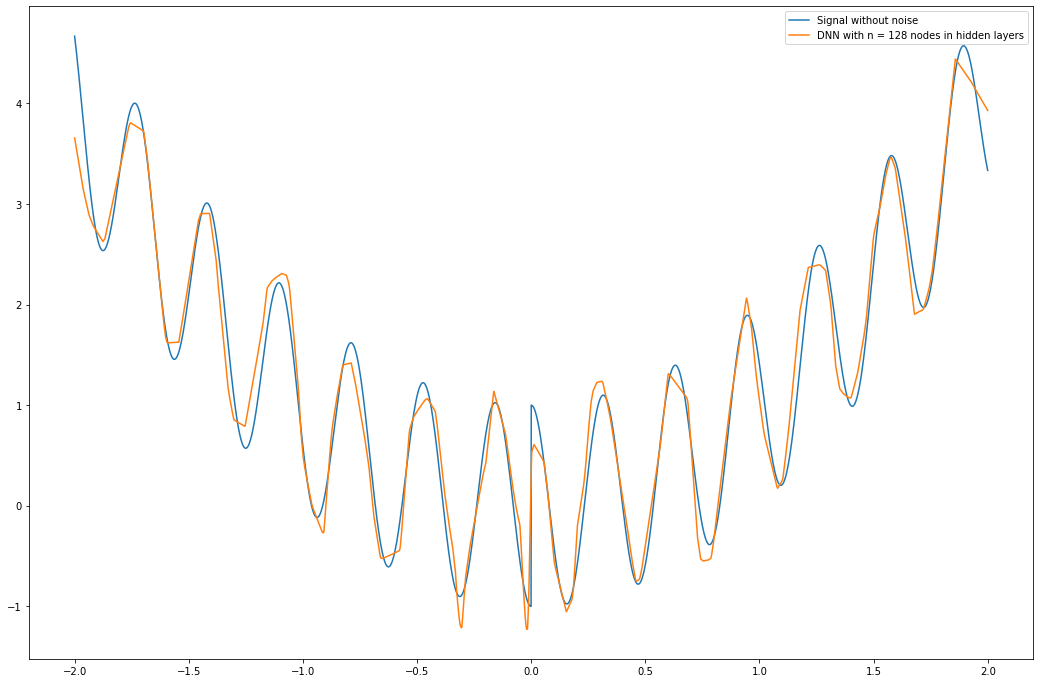

In [19]:
plt.figure(figsize=(18,12))
plt.plot(x,y,label="True noisy signal")
plt.plot(x,z,label="DNN with n = " + str(n) + ' nodes in hidden layers')
plt.legend()   
plt.show()

plt.figure(figsize=(18,12))
plt.plot(x,f(x),label="Signal without noise")
plt.plot(x,z,label="DNN with n = " + str(n) + ' nodes in hidden layers')
plt.legend()   
plt.show()

# Wowsa! The performance is outstanding